In [3]:
!cat data/airports.csv | head -n 10

YKM
YEI
AGN
MOF
GTE
YFH
MWZ
YQG
GAJ
AKV


In [22]:
airports = open("data/airports.csv").read().split("\n")
airports = filter(lambda e: len(e)!=0,airports)

In [23]:
from GeoBases import GeoBase
geo_o = GeoBase(data="ori_por", verbose=False)

In [24]:
geo_o.get("YKM")["lat"]

'46.57'

In [25]:
import math
def toWebMercator(xLon, yLat):
    # Check if coordinate out of range for Latitude/Longitude
    if (abs(xLon) > 180) and (abs(yLat) > 90):
        return
 
    semimajorAxis = 6378137.0  # WGS84 spheriod semimajor axis
    east = xLon * 0.017453292519943295
    north = yLat * 0.017453292519943295
 
    northing = 3189068.5 * math.log((1.0 + math.sin(north)) / (1.0 - math.sin(north)))
    easting = semimajorAxis * east
 
    return [easting, northing]

In [26]:
import numpy as np
def extract_coord(code):
    try:
        airport = geo_o.get(code)
        webcoords = toWebMercator(float(airport["lng"]),float(airport["lat"]))
        return {'code':code, 'lat':airport["lat"],'lng':airport["lng"],'webx':webcoords[0],'weby':webcoords[1]}
    except:
        return {'code':code,'lat':np.nan,'lng':np.nan,'webx':np.nan,'weby':np.nan}

airports = map(extract_coord,airports)

In [28]:
import pandas as pd
airportsdf=pd.DataFrame(airports)

In [29]:
airportsdf.head()

,code,lat,lng,webx,weby
0,YKM,46.57,-120.5,-1.341400e+07,5.872167e+06
1,YEI,40.25528,29.5625,3.290882e+06,4.903109e+06
2,AGN,57.5,-134.6,-1.498360e+07,7.863009e+06
3,MOF,-8.633,122.3,1.361437e+07,-9.646782e+05
4,GTE,-14,136.5,1.519511e+07,-1.574217e+06


In [30]:
import datashader as ds

In [31]:
from datashader import transfer_functions as tf

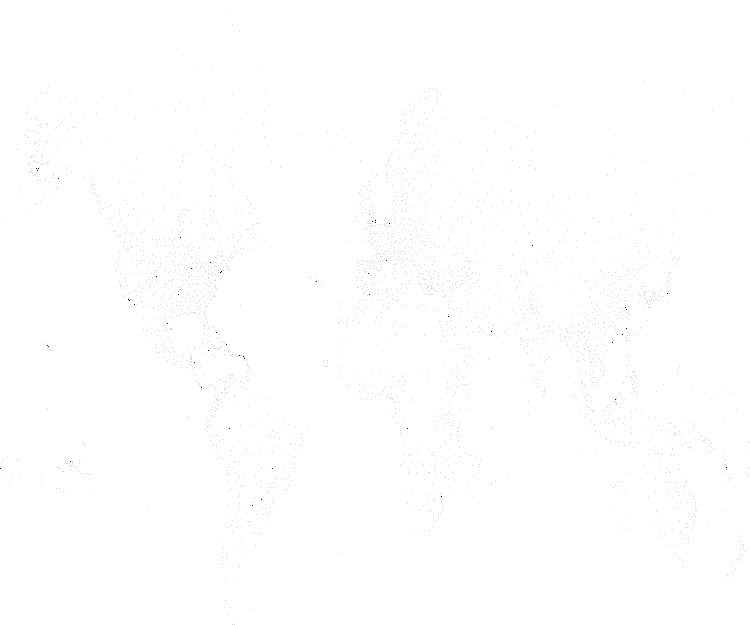

In [38]:
x_range=[airportsdf["webx"].min(),airportsdf["webx"].max()]
y_range=[airportsdf["weby"].min(),airportsdf["weby"].max()]
plot_width=750
plot_height=int(plot_width/1.2)

cvs = ds.Canvas(plot_width=plot_width,plot_height=plot_height,y_range=y_range,x_range=x_range)
points = cvs.points(airportsdf,'webx','weby')
img = tf.shade(points,cmap="black")
img

In [39]:
from bokeh.plotting import figure, show, output_notebook
output_notebook()

Loading BokehJS ...

In [40]:
def base_plot(tools='pan,wheel_zoom,reset',plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p
    
options = dict(line_color=None, fill_color='blue', size=5)

In [45]:
from functools import partial
from datashader.utils import export_image
from datashader.bokeh_ext import InteractiveImage
from bokeh.tile_providers import CARTODBPOSITRON

export = partial(export_image, export_path="export")
world = (x_range,y_range)

def create_image(x_range,y_range,w=plot_width,h=plot_height):
    cvs = ds.Canvas(plot_width=plot_width,plot_height=plot_height,y_range=y_range,x_range=x_range)
    points = cvs.points(airportsdf,'webx','weby')
    img = tf.shade(points,cmap="black")
    return tf.dynspread(img, threshold=0.3, max_px=4)

p = base_plot()
p.add_tile(CARTODBPOSITRON)
export(create_image(*world),"Airports")
InteractiveImage(p,create_image)

In [ ]:
image